##U-Net for Image Segmentation

This architecture is also a fully convolutional network (FCN). The key difference is the implementation of skip connections from the encoder to the decoder.

This U-Net will be able to output segmentation masks that shows which pixels of an input image are part of the background, foreground, and outline

Example:
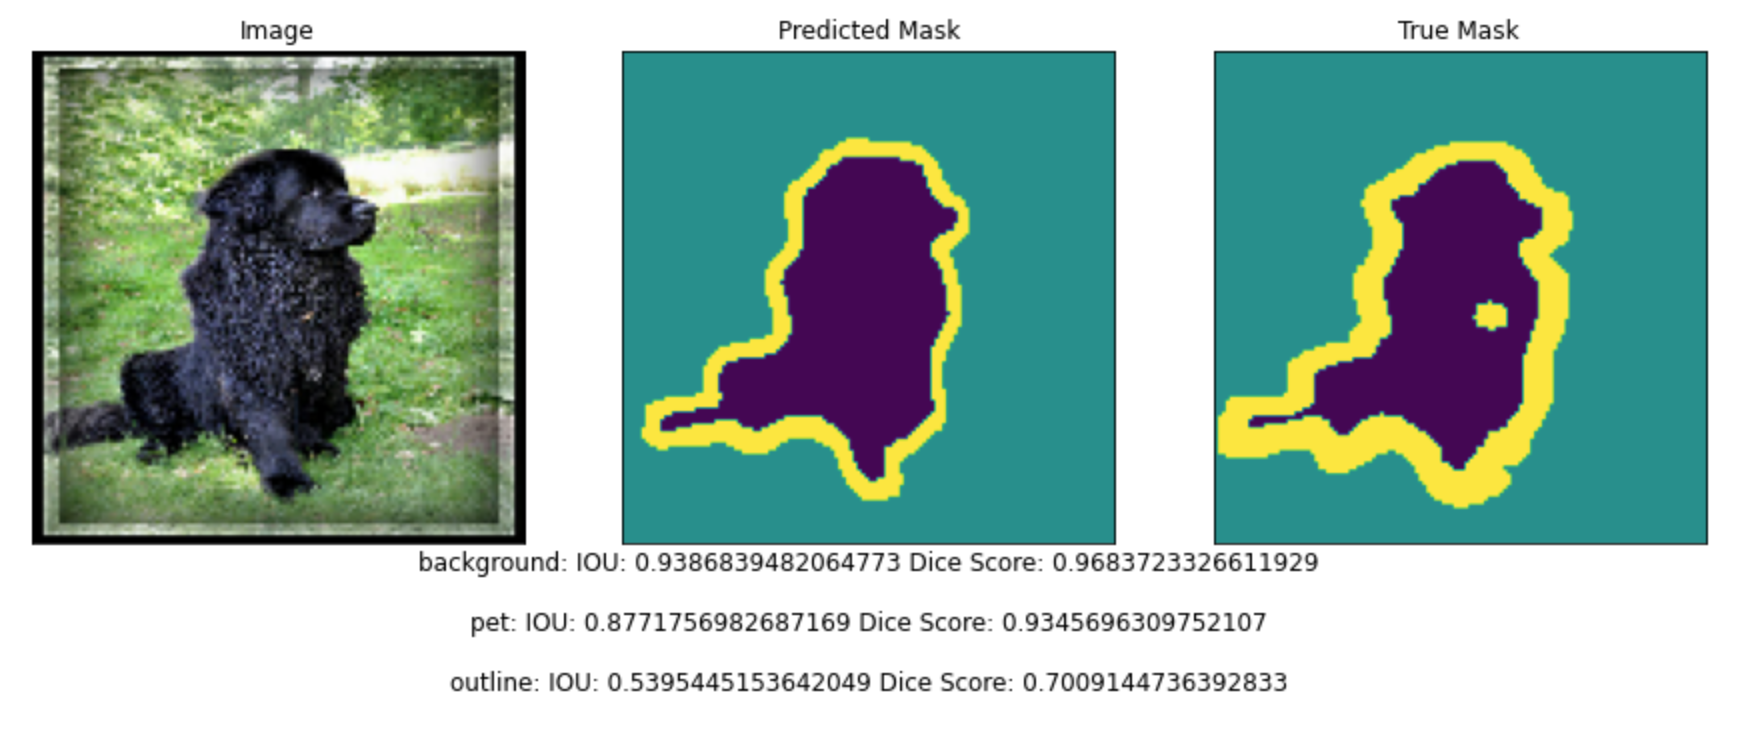

##Imports 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

##Download the Oxford-IIIT Pets Dataset

This dataset contains pet images, their classes, segmentation masks, and head region-of-interest
* Use only the images and segmentation masks 


Luckily, this dataset is already in TensorFlow Datasets so it can be easily downloaded
* The cell below will download the dataset and place the results in a dictionary named `dataset`
* It will also collect info about the dataset that will be assigned to a variable `info`

In [2]:
# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTIYAR2/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteTIYAR2/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [3]:
#Check contents
print(dataset.keys())

dict_keys(['test', 'train'])


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    version=3.2.0,
    description='The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
images for each class. The images have large variations in scale, pose and
lighting. All images have an associated ground truth annotation of breed.',
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=7349,
    splits={
        'test': 3669,
        'train': 3680,
    },
    supervised_keys=('image', 'label'),
    citation="""@InProceedings{parkhi12a,
      author       = "Parkhi, O. M. and Vedaldi, A. and Zisserman, A. and Ja

##Prepare the dataset 

Prep the train and test sets. The following utility functions preprocess the data:
* Simple augmentation 
* normalizing the pixel values 
* resizing the images 

The indicies for each label in the dataset are:
* `0` for pet / foreground
* `1` for background
* `2` for outline

In [5]:
def random_flip(input_image, input_mask):
  """
  Performs a random flip on the image and mask
  """

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)
    
  return input_image, input_mask

In [6]:
def normalize(input_image, input_mask):
  """
  Normalize the input image pixel values to be from [0,1].
  Subtracts 1 from the mask labels to have a range from [0,2]
  """

  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1

  return input_image, input_mask

In [7]:
@tf.function #graph mode!
def load_image_train(datapoint):
  """
  Resizes, normalizes, and flips the training data
  """

  input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
  
  input_image, input_mask = random_flip(input_image, input_mask)
  
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
def load_image_test(datapoint):
  """
  Resizes and normalizes the test data
  """

  input_image = tf.image.resize(datapoint['image'], (128,128), method='nearest')
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128,128), method='nearest')

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

Call the utility functions to prep the train and test sets

The downloaded dataset already contains the training and test splits so just access them through the dicitonary keys. 

In [9]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

Prep the batches for training and testing 

In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000

#Shuffle and group the train set into batches 
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

#Perform a prefetch to optimize processing 
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

#Group the test set into batches 
test_dataset = test.batch(BATCH_SIZE)

##Visualization Utilities



In [11]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
  '''displays a list of images/masks and overlays a list of IOU and Dice Scores'''
  
  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string) 


def display(display_list,titles=[], display_string=None):
  '''displays a list of images/masks'''

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)
  
  plt.show()


def show_image_from_dataset(dataset):
  '''displays the first image and its mask from a dataset'''

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  '''plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

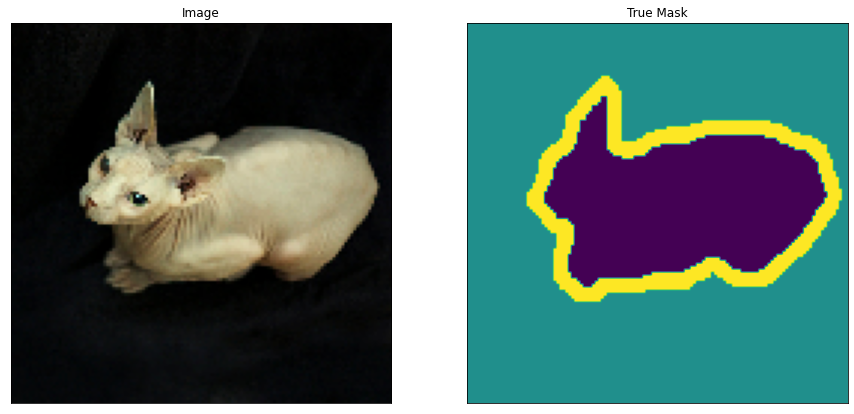

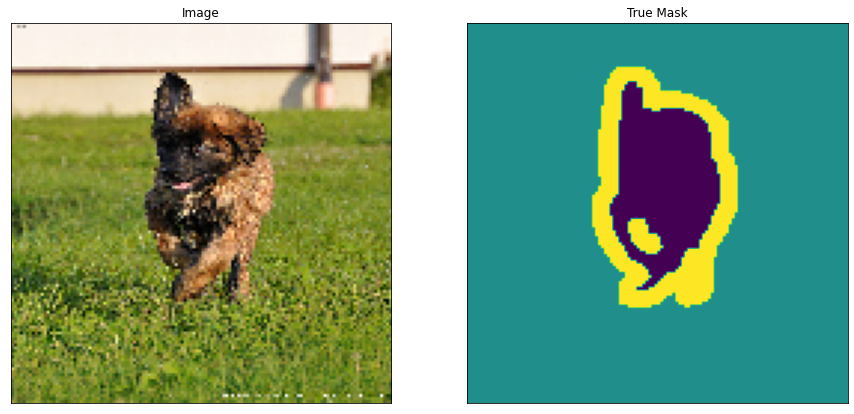

In [12]:
#Display an image from the train set 
show_image_from_dataset(train)
show_image_from_dataset(test)

##Define the model 

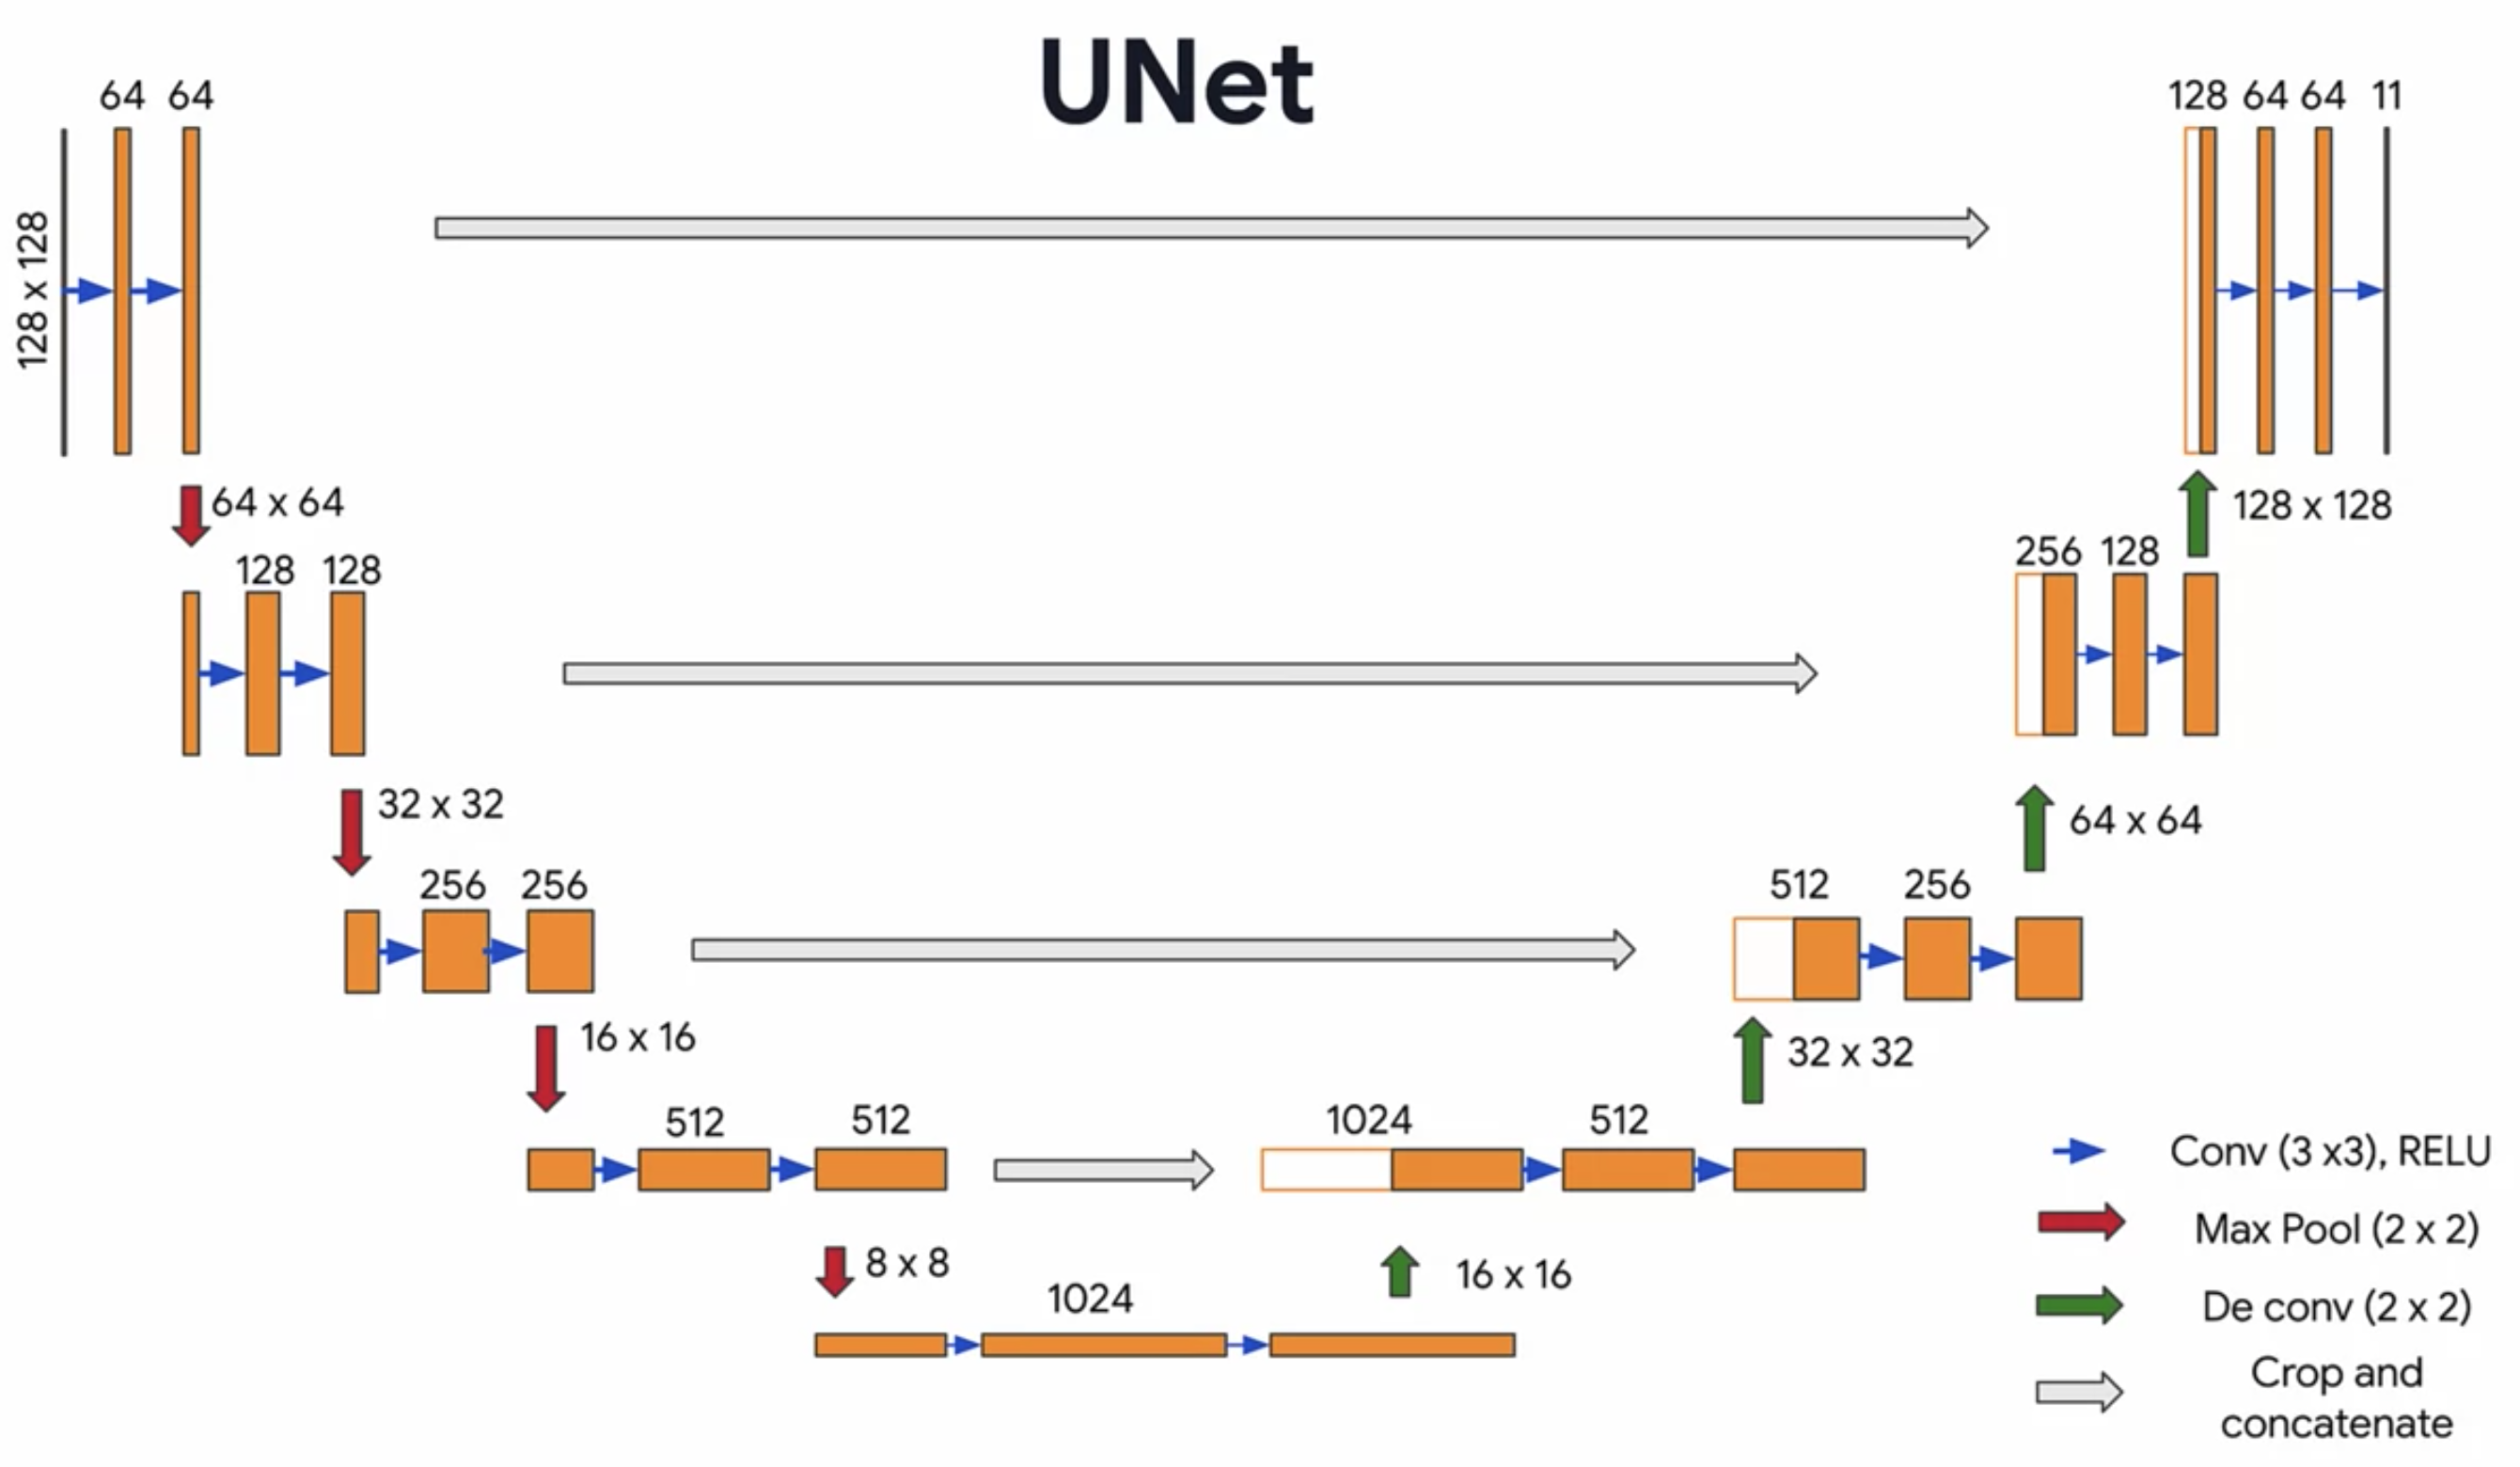

U-Net consists of an encoder (down-sampler) and a decoder (up-sampler) with a bottle neck in between. 

The gray arrows correspond to the skip connections that concatenate the encoder block outputs to each stage of the decoder 

##Encoder

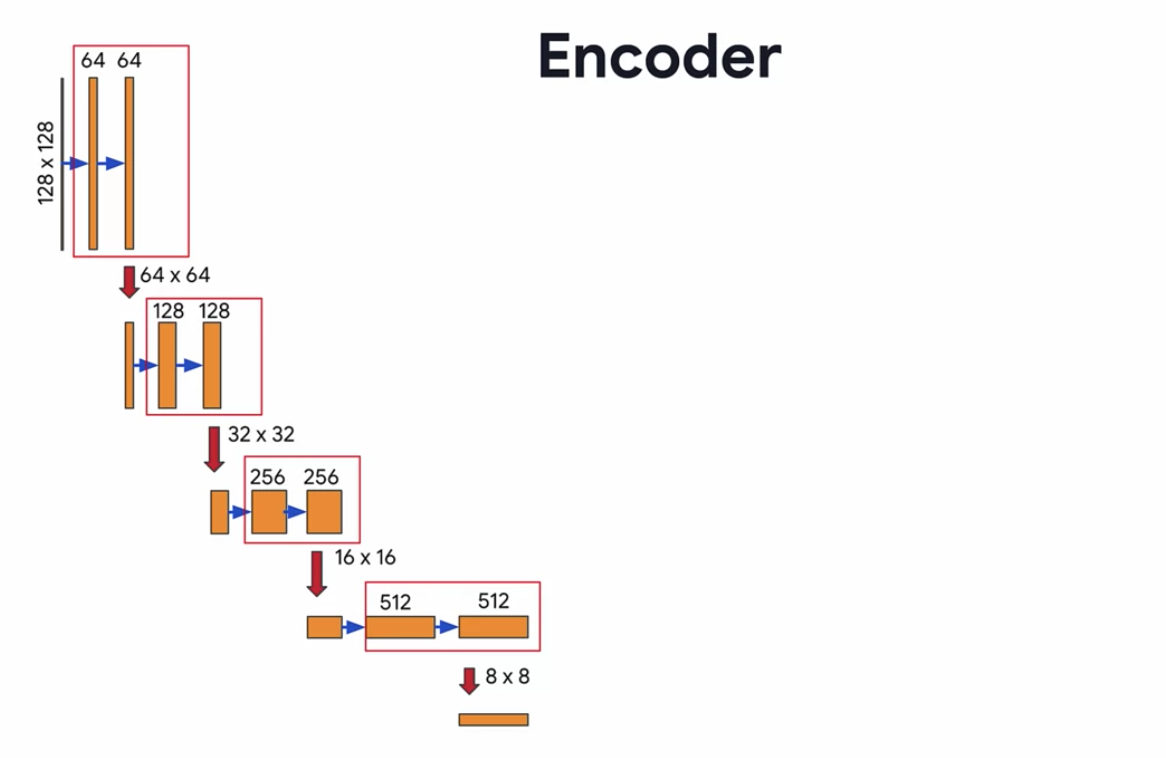

The encoder utilities will have three funcitons:
* `conv2d_block()` - to add two convolution layers with ReLu activations 
* `encoder_block()` - to add pooling and dropout to the conv2d blocks
 * U-Net requires that the output of the convolution layers be saved at each block so this funciton will return two values to take that into account (i.e. output of the conv block and the dropout)
* `encoder()` - to build the entire encoder. It returns the output of the last encoder block as well as the output of the previous conv blocks (these will be concatenated to the decoder blocks)

##Encoder Utilities

In [13]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
  """
  Adds convolution layers with the parameters passed to it

  Args:
    input_tensor (tensor): the input tensor
    n_filters (int): number of filters 
    kernel_size (int): kernel size of the convolution layer 
  """

  #first layer 
  x = input_tensor
  
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters,
                               kernel_size = (kernel_size, kernel_size),
                               kernel_initializer = 'he_normal',
                               padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x
  

In [14]:
def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  """
  Adds two convolutional blocks and then perfroms sampling on output of convolution

  Args:
    input_tensor (tensor):  the input tensor
    n_filters (int): number of filters 
    kernel_size (int): kernel size of convolution layer 

  Returns:
    f: the output features of the convolution block 
    p: the maxpooled features with dropout 
  """

  f = conv2d_block(inputs, n_filters = n_filters)
  
  p = tf.keras.layers.MaxPool2D(pool_size = (2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p

In [15]:
def encoder(inputs):
  """
  This function defines the encoder / downsampling path

  Args:
    inputs (tensor): batch of input images 

  Returns:
    p4: the output maxpooled features of the last encoder block 
    (f1, f2, f3, f4): the output features of all the encoder blocks 
  """

  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

##Bottleneck

A bottleneck follows the encoder block and is used to extract more features

It doesn't have a pooling layer so the dimentionality stays the same 
* Use the `conv2d_block()` utility to implement this 

In [16]:
def bottleneck(inputs):
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

##Decoder 

The decoder upsamples the features back to the original image size

At each upscaling level, the output of the corresponding encoder block will be concatenated witht he decoder block at that level before feeding it to the next decoder block

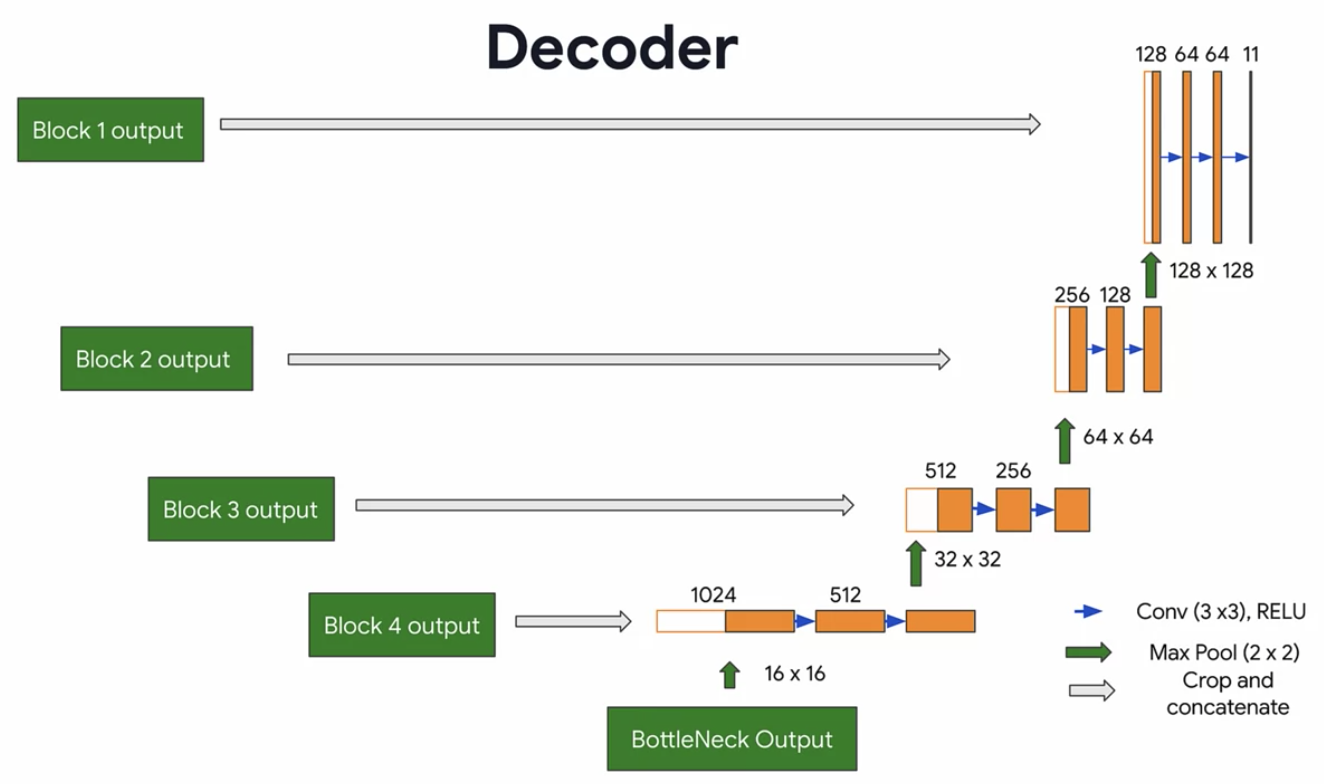

##Decoder Utilities

These utilities will reuse the `conv2d_block` and will basically be the reverse of the encoding utilities 

In [17]:
#Decoder Utilities 

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  """
  Defines the one decoder block of the U-Net

  Args:
    inputs (tensor): batch of input tensors 
    conv_outputs (tensor): features from an encoder block (f1, f2, etc.)
    n_filters (int): number of filters 
    kernel_size (int): kernel size of de-convolutional layer 
    strides (int): strides for de-convolutional layer / upsampling layer
    padding (string): 'same' or 'valid' tells if shape will be by zero padding 
  
  Returns:
    c (tensor): output features of the decoder block
  """

  u = tf.keras.layers.Conv2DTranspose(filters = n_filters,
                                      kernel_size = kernel_size,
                                      strides = strides,
                                      padding = 'same',)(inputs)

  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters = n_filters, kernel_size=3)

  return c

In [18]:
def decoder(inputs, convs, num_classes):
  """
  Defines the decoder of the U-Net chaining together 4 decoder blocks

  Args:
    inputs (tensor): batch of input features 
    convs (tuple): features from the encoder blocks 
    num_classes (int): number of classes in the label map

  Returns:
    outputs (tensor): the pixel wise label map of the image
  """

  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, conv_output =  f4, n_filters = 512, kernel_size = (3,3), strides = (2,2), dropout = 0.3)

  c7 = decoder_block(c6, conv_output =  f3, n_filters = 256, kernel_size = (3,3), strides = (2,2), dropout = 0.3)

  c8 = decoder_block(c7, conv_output =  f2, n_filters = 128, kernel_size = (3,3), strides = (2,2), dropout = 0.3)
  
  c9 = decoder_block(c8, conv_output =  f1, n_filters = 64, kernel_size = (3,3), strides = (2,2), dropout = 0.3)

  outputs = tf.keras.layers.Conv2D(num_classes, (1,1), activation='softmax')(c9)

  return outputs

##Defing the Model 

Putting it all together:
* The `num_classes` is `3` since there are three possible labels for each pixel: pet, background, outline

In [19]:
NUM_CLASSES = 3

def unet():
  """
  Defines the U-Net by connecting the encoder, bottleneck, and decoder 
  """

  #Specify the input shape 
  inputs = tf.keras.layers.Input(shape=(128, 128, 3,))

  #Feed the inputs to the encoder 
  encoder_output, convs = encoder(inputs)

  #Feed the encoder output to the bottleneck 
  bottle_neck = bottleneck(encoder_output)

  #Feed the bottleneck, convs, and encoder block outputs to the decoder
  #Specify the number of classes 
  outputs = decoder(bottle_neck, convs, num_classes = NUM_CLASSES)

  #Create the model 
  model = tf.keras.Model(inputs = inputs, 
                         outputs = outputs)

  return model

model = unet()

##Compile and Train the Model 

Use `sparse_categorical_crossentropy` for the loss becasue the network is trying to assign each picel label similar to multi-class prediction
* In the segmentaiton mask, each pixel has either a `0`, `1`, or `2`
* The network is outputting three channels 
 * Each channel is trying to predict a class

In [20]:
#Configure the optimizer, Loss and metrics for training
model.compile(optimizer = tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [21]:
#Configure the training parameters and train the mdoel 

TRAIN_LENGTH = info.splits['train'].num_examples #info is the variable created earlier
EPOCHS = 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples // BATCH_SIZE // VAL_SUBSPLITS

#This model will take about 20 min to trun 
model_history = model.fit(train_dataset,
                          epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/10
57/57 [==============================] - 60s 619ms/step - loss: 0.9566 - accuracy: 0.5732 - val_loss: 0.8342 - val_accuracy: 0.6223
Epoch 2/10
57/57 [==============================] - 41s 638ms/step - loss: 0.7825 - accuracy: 0.6526 - val_loss: 0.7867 - val_accuracy: 0.6305
Epoch 3/10
57/57 [==============================] - 36s 634ms/step - loss: 0.6710 - accuracy: 0.7274 - val_loss: 0.6885 - val_accuracy: 0.7180
Epoch 4/10
57/57 [==============================] - 37s 645ms/step - loss: 0.6009 - accuracy: 0.7585 - val_loss: 0.5786 - val_accuracy: 0.7764
Epoch 5/10
57/57 [==============================] - 37s 656ms/step - loss: 0.5457 - accuracy: 0.7840 - val_loss: 0.5258 - val_accuracy: 0.7970
Epoch 6/10
57/57 [==============================] - 38s 661ms/step - loss: 0.4957 - accuracy: 0.8060 - val_loss: 0.4697 - val_accuracy: 0.8142
Epoch 7/10
57/57 [==============================] - 39s 677ms/step - loss: 0.4648 - accuracy: 0.8188 - val_loss: 0.4681 - val_accuracy: 0.8156

##Plot Metrics 

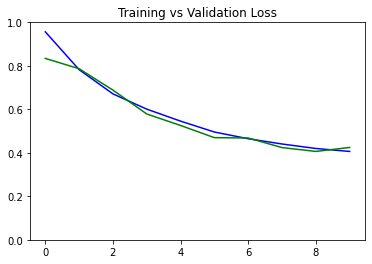

In [22]:
plot_metrics('loss', title='Training vs Validation Loss', ylim=1)

##Make Predictions 

Use the test dataset to feed input images that the model hasn't seen before

In [31]:
#Prediction utilities

def get_test_image_and_annotation_arrays():
  """
  Unpacks the test dataset and returns the input images and segmentation masks 
  """

  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)

  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()

  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]
  images = images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % BATCH_SIZE))]

  return images, y_true_segments 

In [27]:
def create_mask(pred_mask):
  """
  Creates the segmentation mask by getting the channel with the highest probability. 
  """

  pred_mask = tf.argmax(pred_mask, axis = -1)
  pred_mask = pred_mask[..., tf.newaxis]
  
  return pred_mask[0].numpy()

In [28]:
def make_predictions(image, mask, num=1):
  """
  Feeds an image to a model and returns the predicted mask
  """

  image = np.reshape(image, (1, image.shape[0], image.shape[1], image.shape[2]))

  pred_mask = model.predict(image)
  pred_mask = create_mask(pred_mask)

  return pred_mask

##Compute class wise metrics 

Compute IOU and the Dice Score

In [34]:
#Class-wise metrics utilities 

def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.0001
  for i in range(3):

    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score = 2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))

    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

##Setup the Ground Truth and Predictions 

In [32]:
#Get the ground truth from the test set 
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

#Feed the test set to the model to get the predicted 
results = model.predict(test_dataset, steps=info.splits['test'].num_examples // BATCH_SIZE)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

In [41]:
#Compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [42]:
#Show the IOU and Dice Scores for each class
print('IOU:')
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print('{}{}{}'.format(class_names[idx], spaces, iou))

print('\nDice Scores:')
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print('{}{}{}'.format(class_names[idx], spaces, dice_score))



IOU:
pet         0.69474850016303
background  0.8151801588917559
outline     0.2997812865495494

Dice Scores:
pet         0.8198838943928173
background  0.8981809931093139
outline     0.461279585503371


##Show Predictions

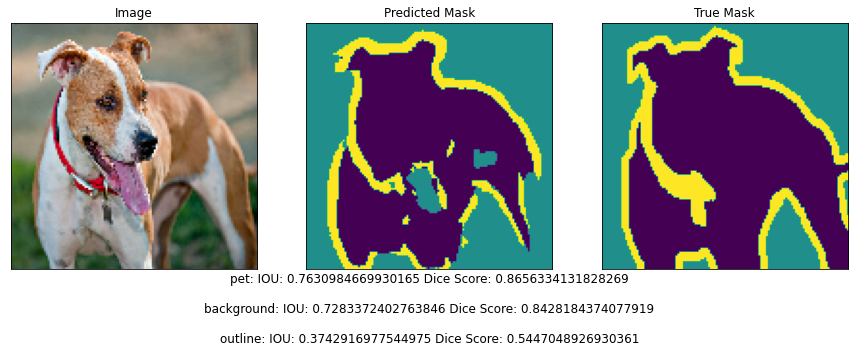

In [43]:
#Input a number between 0 and 3647 to pick an image from the dataset 
integer_slider = 3646

#Get the prediction mask 
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

#Compute the class wise metrics 
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)

#Overlay the metrics with the images 
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)